In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import torchbnn as bnn


In [21]:
#import creep data
creep_df = pd.read_csv('../PI_Data/PI_SS316_dataset.csv')
creep_df

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature,creep_rupture_life
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382,29.2
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285,34.5
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716,38.8
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759,39.0
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669,40.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788,142185.9
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890,152758.0
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471,173814.3
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538,178190.4


In [22]:
Log_Creep_Life = np.log10(creep_df['creep_rupture_life'])
creep_df['Log_Creep_Life'] = Log_Creep_Life
creep_df = creep_df.drop(columns = ['creep_rupture_life'])

In [23]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Material               617 non-null    int64  
 1   C                      617 non-null    float64
 2   Si                     617 non-null    float64
 3   Mn                     617 non-null    float64
 4   P                      617 non-null    float64
 5   S                      617 non-null    float64
 6   Ni                     617 non-null    float64
 7   Cr                     617 non-null    float64
 8   Mo                     617 non-null    float64
 9   Cu                     617 non-null    float64
 10  Ti                     617 non-null    float64
 11  Al                     617 non-null    float64
 12  B                      617 non-null    float64
 13  N                      617 non-null    float64
 14  Nb+Ta                  617 non-null    float64
 15  Elonga

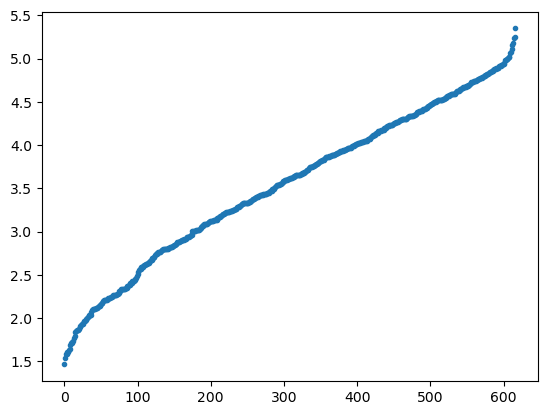

In [24]:
plt.plot(creep_df['Log_Creep_Life'], '.')

In [25]:
features = creep_df.iloc[:, 0:21]
targets = creep_df.iloc[:, 21]
features

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,Al,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.015,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.018,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.011,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.021,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.027,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538


Run # 1 Fold # 1
MSE : 3.15, KL : 0.64
MSE : 0.06, KL : 0.84
MSE : 0.02, KL : 0.89
Pearson CC: 0.9938615425142061
R2 score: 0.9803681104024289
RMSE: 0.12485891580581665
MAE: 0.10030612349510193
********************
Coverage: 91.93548387096777
Interval Width: 0.45899105072021484
Composite Metric: 1.234189058074597


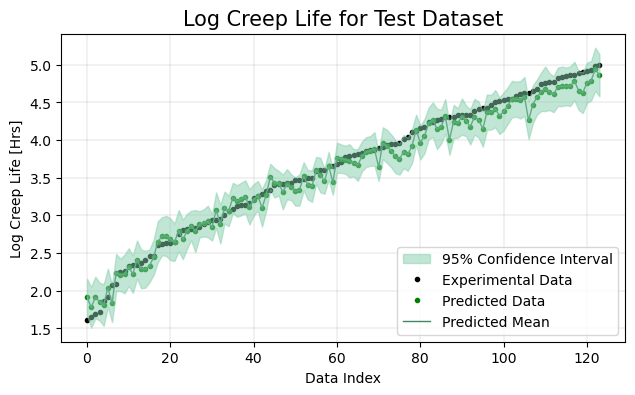

****************************************
Run # 1 Fold # 2
MSE : 1.59, KL : 0.64
MSE : 0.01, KL : 0.85
MSE : 0.08, KL : 0.89
Pearson CC: 0.9920386498300531
R2 score: 0.9792260742298933
RMSE: 0.1336868852376938
MAE: 0.09748757630586624
********************
Coverage: 95.16129032258067
Interval Width: 0.486034631729126
Composite Metric: 1.2280763165014206


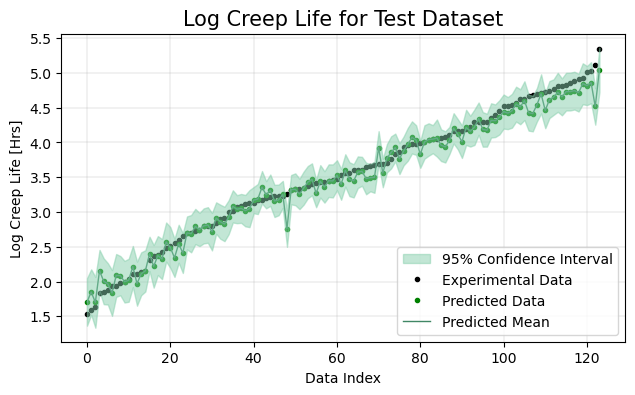

****************************************
Run # 1 Fold # 3
MSE : 5.23, KL : 0.64
MSE : 0.02, KL : 0.85
MSE : 0.05, KL : 0.90
Pearson CC: 0.9950979026867767
R2 score: 0.989657965222916
RMSE: 0.09552434086799622
MAE: 0.07787083834409714
********************
Coverage: 99.18699186991866
Interval Width: 0.5010862350463867
Composite Metric: 1.242818558675645


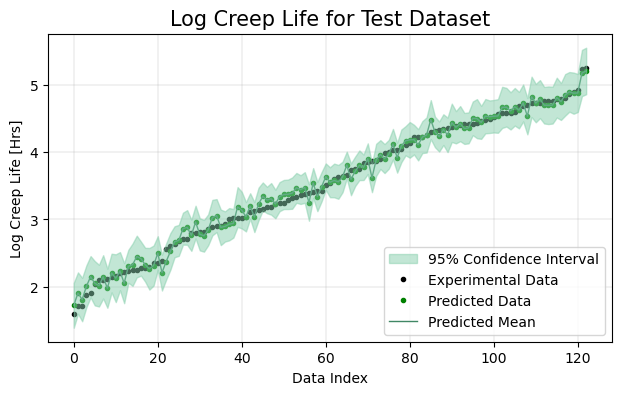

****************************************
Run # 1 Fold # 4
MSE : 3.21, KL : 0.63
MSE : 0.04, KL : 0.83
MSE : 0.03, KL : 0.87
Pearson CC: 0.9923841845582593
R2 score: 0.9846611234649335
RMSE: 0.10680234432220459
MAE: 0.07888342440128326
********************
Coverage: 95.93495934959346
Interval Width: 0.49042701721191406
Composite Metric: 1.229272039555592


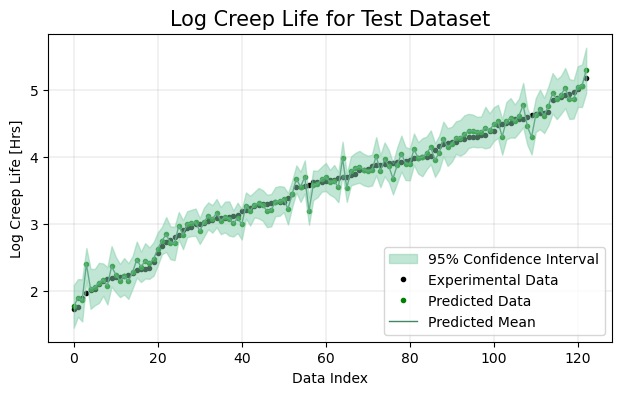

****************************************
Run # 1 Fold # 5
MSE : 3.18, KL : 0.65
MSE : 0.03, KL : 0.86
MSE : 0.03, KL : 0.90
Pearson CC: 0.9934404894677231
R2 score: 0.9820251612960521
RMSE: 0.11787642538547516
MAE: 0.08823449164628983
********************
Coverage: 93.49593495934955
Interval Width: 0.44948673248291016
Composite Metric: 1.25740945493054


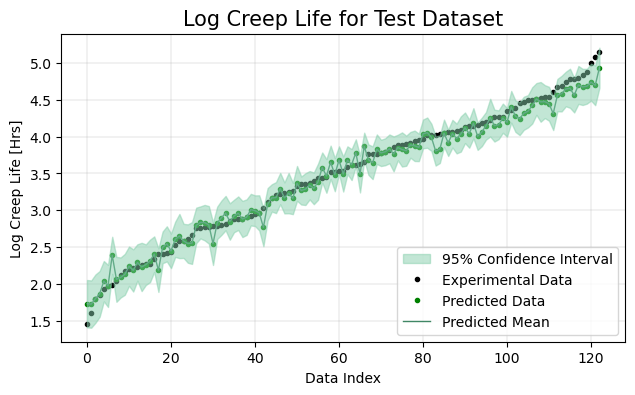

****************************************


In [26]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)


            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)
            y_train = torch.unsqueeze(y_train, dim=1)
            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)
            y_test = torch.unsqueeze(y_test, dim=1)


            # create pytorch dataset class
            class MyDataset(Dataset):
                def __init__(self, train_data, train_targets):
                    self.train_features = train_data
                    self.train_labels = train_targets

                def __len__(self):
                    return self.train_features.shape[0]

                def __getitem__(self, idx):
                    feature = self.train_features[idx]
                    label = self.train_labels[idx]

                    return feature, label


            train_dataset = train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
            model = nn.Sequential(
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=21, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=1),
            )

            # define the loss function and optimizer
            mse_loss = nn.MSELoss()
            kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            kl_weight = 0.01

            optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.95)
            for step in range(3000):
                  for n, data in enumerate(train_dataloader):
                        traning_data, training_label = data


                        y_pred = model(traning_data)
                        mse = mse_loss(y_pred, training_label)
                        kl = kl_loss(model)
                        cost = mse + kl_weight*kl

                        optimizer.zero_grad()
                        cost.backward()
                        optimizer.step()

                  if step % 1000==0:
                        print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
            y_pred_test = model(x_test)

            # inference
            n_samples = 1000

            # compute predictions
            y_preds = [model(x_test).clone().detach().numpy() for _ in range(n_samples)]
            y_preds = np.array(y_preds)
            # mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

            ## Metrics for evaluating the uncertainty quantification of the model

            # Coverage
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')


            # Prediction interval width

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')



            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            fig.delaxes(ax[1])

            plt.show()


            print(40*'*')

In [27]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.993862,0.980368,0.124859,0.100306
1,0.992039,0.979226,0.133687,0.097488
2,0.995098,0.989658,0.095524,0.077871
3,0.992384,0.984661,0.106802,0.078883
4,0.993440,0.982025,0.117876,0.088234


In [28]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.993365,0.001093,0.983188,0.003716,0.11575,0.013404,0.088556,0.009227


In [29]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,91.935484,0.458991,1.234189
1,95.161290,0.486035,1.228076
2,99.186992,0.501086,1.242819
3,95.934959,0.490427,1.229272
4,93.495935,0.449487,1.257409


In [30]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,95.142932,2.448771,0.477205,0.019612,1.238353,0.010849
